# ver raw

In [ ]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def leer_numero_frames(archivo):
    with open(archivo, 'r') as f:
        for _ in range(6):  # Saltar las primeras 6 líneas
            next(f)
        linea_fastframe = next(f)
    return int(linea_fastframe.split(',')[1])

def cargar_frames_desde_csv(archivo, tiempo_col='Tiempo (s)', voltaje_col='Voltaje (V)'):
    N_frames = leer_numero_frames(archivo)
    datos = pd.read_csv(archivo, skiprows=7)
    tiempo = datos[tiempo_col].values
    voltaje = datos[voltaje_col].values

    puntos_por_frame = len(tiempo) // N_frames

    frames = []
    for i in range(N_frames):
        inicio = i * puntos_por_frame
        fin = (i + 1) * puntos_por_frame
        frames.append((tiempo[inicio:fin], voltaje[inicio:fin]))
    
    return frames

def mostrar_3_frames_random(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith(".csv")]
    if not archivos:
        print("No se encontraron archivos CSV.")
        return

    archivo = random.choice(archivos)
    ruta = os.path.join(carpeta, archivo)
    print(f"Mostrando 3 frames aleatorios del archivo: {archivo}")

    frames = cargar_frames_desde_csv(ruta)

    if len(frames) < 3:
        print("El archivo tiene menos de 3 frames.")
        return

    frames_random = random.sample(frames, 3)

    plt.figure(figsize=(12, 6))
    for i, (tiempo, voltaje) in enumerate(frames_random):
        plt.plot(tiempo, voltaje, label=f"Frame aleatorio {i+1}")
    
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.title(f"Tres Frames Aleatorios del CSV {carpeta_csv}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ruta de la carpeta con los archivos CSV
carpeta_csv = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\adquisiciones\PMT\8,66v 10k"
mostrar_3_frames_random(carpeta_csv)


NameError: name 'N_frames' is not defined

# laburo los datos

In [50]:
import os
import csv

def check_and_fix_csv(file_path):
    header_needed = ["", "", "", "Tiempo (s)", "Voltaje (V)"]
    temp_file = file_path + ".tmp"
    modified = False

    with open(file_path, 'r', newline='', encoding='utf-8') as infile, open(temp_file, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for i, row in enumerate(reader):
            if i == 7:  # Octava fila (índice 7)
                if row == header_needed:  
                    print(f"{file_path}: La fila 8 ya contiene el encabezado correcto.")
                    return  # Sale temprano si el encabezado es correcto
                writer.writerow(header_needed)  # Escribe el encabezado correcto
                modified = True
            writer.writerow(row)

    if modified:
        os.replace(temp_file, file_path)  # Reemplaza el archivo original solo si se modificó
        print(f"{file_path}: Encabezado agregado en la fila 8.")
    else:
        os.remove(temp_file)  # Elimina el archivo temporal si no se usó

# Procesar todos los archivos CSV en una carpeta
def process_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            check_and_fix_csv(file_path)

# Ruta de la carpeta con archivos CSV
folder_path = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\adquisiciones\PMT\oscuro (con scint)"
process_folder(folder_path)


C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\adquisiciones\PMT\oscuro (con scint)\250401_151512_Ch1.csv: Encabezado agregado en la fila 8.


# adquisicion histograma cragas totales y todo

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import simpson

plt.close("all")

resistencia = 50  # 50 ohms o 1Mohm
umbral_deteccion = -0.0035  # Umbral para detectar un pico

# CAMBIAR SEGÚN TU DIRECTORIO
directorio_trabajo = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos"

def leer_numero_frames(archivo):
    with open(archivo, 'r') as f:
        for _ in range(6):  # Saltar las primeras 6 líneas
            next(f)
        linea_fastframe = next(f)
    return int(linea_fastframe.split(',')[1])

def procesar_adquisicion(tiempo, voltaje):
    media_base = np.median(voltaje)  # Se usa la mediana para evitar outliers
    voltaje_sin_base = voltaje - media_base

    indices_pico = np.where(voltaje_sin_base < umbral_deteccion)[0]
    if len(indices_pico) == 0:
        return None, None

    inicio_pico, fin_pico = indices_pico[0], indices_pico[-1]
    
    tiempo_pico = tiempo[inicio_pico:fin_pico + 1]
    voltaje_pico = voltaje_sin_base[inicio_pico:fin_pico + 1]
    carga = -simpson(voltaje_pico, tiempo_pico) / resistencia
    tiempo_total = tiempo[-1] - tiempo[0]  # Duración de la adquisición
    
    # Devolver solo cargas positivas
    return carga if carga > 0 else None, tiempo_total

def procesar_csv(archivo, tiempo_col='Tiempo (s)', voltaje_col='Voltaje (V)'):
    N_adquisiciones = leer_numero_frames(archivo)
    datos = pd.read_csv(archivo, skiprows=7)
    tiempo = datos[tiempo_col].values
    voltaje = datos[voltaje_col].values
    
    tamaño_adquisicion = len(tiempo) // N_adquisiciones
    cargas = []
    tiempo_total = 0

    for i in range(N_adquisiciones):
        inicio, fin = i * tamaño_adquisicion, (i + 1) * tamaño_adquisicion
        carga, tiempo_adq = procesar_adquisicion(tiempo[inicio:fin], voltaje[inicio:fin])
        if carga is not None:
            cargas.append(carga)
        if tiempo_adq is not None:
            tiempo_total += tiempo_adq
    
    return cargas, tiempo_total

def procesar_carpeta(carpeta):
    cargas_totales = []
    tiempo_total_adquisicion = 0
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    for archivo in archivos:
        try:
            cargas, tiempo_total = procesar_csv(os.path.join(carpeta, archivo))
            cargas_totales.extend(cargas)
            tiempo_total_adquisicion += tiempo_total
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    
    cargas_arr = np.array(cargas_totales)
    # ...
    carga_total = np.sum(cargas_arr)

    # Filtrar cargas superiores a 6.5e-12 C (manteniendo solo cargas válidas)
    cargas_filtradas = cargas_arr[cargas_arr <= 6.5e-12]

    # Generar histograma con solo cargas positivas y dentro del umbral
    plt.figure(figsize=(12, 6))
    counts, bins, _ = plt.hist(cargas_filtradas, bins=500, edgecolor='black', alpha=0.7, log=True)
    plt.xlabel('Carga (Coulombs)')
    plt.ylabel('Número de cuentas (escala logarítmica)')
    plt.title(f'Histograma de Cargas - {len(cargas_filtradas)} eventos (filtrado ≤6.5e-12 C)')
    plt.show()

    # Calcular centros de bins
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Guardar datos sin cargas negativas en un archivo .npz
    datos_path = os.path.join(directorio_trabajo, 'datos_histogramaPVTdia2.npz')
    np.savez(datos_path, 
             cargas_totales=cargas_filtradas,  # Ya filtrado
             bin_centers=bin_centers, 
             frecuencias=counts,
             tiempo_total_adquisicion=tiempo_total_adquisicion,
             carga_total=carga_total)

    carga_por_segundo = carga_total / tiempo_total_adquisicion if tiempo_total_adquisicion > 0 else 0

    print(f"Todos los datos guardados en: {datos_path}")
    print(f"Tiempo total de adquisición: {tiempo_total_adquisicion:.3e} s")
    print(f"Carga total en ese tiempo: {carga_total:.3e} C")
    print(f"Carga colectada por segundo: {carga_por_segundo:.3e} C/s")
# ...


# Ruta de la carpeta con los archivos CSV
carpeta_csv = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\adquisiciones\PMT\pvt"
cargas = procesar_carpeta(carpeta_csv)


Todos los datos guardados en: C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\datos_histogramaPVTdia2.npz
Tiempo total de adquisición: 2.413e-05 s
Carga total en ese tiempo: 3.164e-05 C
Carga colectada por segundo: 1.311e+00 C/s


# procesado descartando tiempos menores a 0 (aparece pico siempre)

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import simpson

plt.close("all")

resistencia = 50  # 50 ohms o 1Mohm
umbral_deteccion = -0.0035  # Umbral para detectar un pico

# CAMBIAR SEGÚN TU DIRECTORIO
directorio_trabajo = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos"

def leer_numero_frames(archivo):
    with open(archivo, 'r') as f:
        for _ in range(6):  # Saltar las primeras 6 líneas
            next(f)
        linea_fastframe = next(f)
    return int(linea_fastframe.split(',')[1])

def procesar_adquisicion(tiempo, voltaje):
    # Recortar solo los tiempos mayores o iguales a 0
    mask = tiempo >= 0
    tiempo = tiempo[mask]
    voltaje = voltaje[mask]
    
    if len(tiempo) == 0:
        return None, None  # Si no queda nada útil, salimos

    media_base = np.median(voltaje)  # Se usa la mediana para evitar outliers
    voltaje_sin_base = voltaje - media_base

    indices_pico = np.where(voltaje_sin_base < umbral_deteccion)[0]
    if len(indices_pico) == 0:
        return None, None

    inicio_pico, fin_pico = indices_pico[0], indices_pico[-1]

    tiempo_pico = tiempo[inicio_pico:fin_pico + 1]
    voltaje_pico = voltaje_sin_base[inicio_pico:fin_pico + 1]
    carga = -simpson(voltaje_pico, tiempo_pico) / resistencia
    tiempo_total = tiempo[-1] - tiempo[0]

    return carga if carga > 0 else None, tiempo_total


def procesar_csv(archivo, tiempo_col='Tiempo (s)', voltaje_col='Voltaje (V)'):
    N_adquisiciones = leer_numero_frames(archivo)
    datos = pd.read_csv(archivo, skiprows=7)
    tiempo = datos[tiempo_col].values
    voltaje = datos[voltaje_col].values
    
    tamaño_adquisicion = len(tiempo) // N_adquisiciones
    cargas = []
    tiempo_total = 0

    for i in range(N_adquisiciones):
        inicio, fin = i * tamaño_adquisicion, (i + 1) * tamaño_adquisicion
        carga, tiempo_adq = procesar_adquisicion(tiempo[inicio:fin], voltaje[inicio:fin])
        if carga is not None:
            cargas.append(carga)
        if tiempo_adq is not None:
            tiempo_total += tiempo_adq
    
    return cargas, tiempo_total

def procesar_carpeta(carpeta):
    cargas_totales = []
    tiempo_total_adquisicion = 0
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    for archivo in archivos:
        try:
            cargas, tiempo_total = procesar_csv(os.path.join(carpeta, archivo))
            cargas_totales.extend(cargas)
            tiempo_total_adquisicion += tiempo_total
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    
    cargas_arr = np.array(cargas_totales)
    carga_total = np.sum(cargas_arr)

    # Filtrar cargas superiores a 6.5e-12 C (manteniendo solo cargas válidas)
    cargas_filtradas = cargas_arr[cargas_arr <= 3e-13]

    # Generar histograma con solo cargas positivas y dentro del umbral
    plt.figure(figsize=(12, 6))
    counts, bins, _ = plt.hist(cargas_filtradas, bins=500, edgecolor='black', alpha=0.7, log=True)
    plt.xlabel('Carga (Coulombs)')
    plt.ylabel('Número de cuentas (escala logarítmica)')
    plt.title(f'Histograma de Cargas - {len(cargas_filtradas)} eventos (filtrado ≤6.5e-12 C)')
    plt.show()

    # Calcular centros de bins
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Guardar datos sin cargas negativas en un archivo .npz
    datos_path = os.path.join(directorio_trabajo, 'datos_histogramapvtposta.npz')
    np.savez(datos_path, 
             cargas_totales=cargas_filtradas,  # Ya filtrado
             bin_centers=bin_centers, 
             frecuencias=counts,
             tiempo_total_adquisicion=tiempo_total_adquisicion,
             carga_total=carga_total)

    print(f"Todos los datos guardados en: {datos_path}")
    print(f"Tiempo total de adquisición: {tiempo_total_adquisicion} s")
    print(f"Carga total en ese tiempo: {carga_total} C")
    
    return cargas_totales

# Ruta de la carpeta con los archivos CSV
carpeta_csv = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\adquisiciones\PMT\pvt"
cargas = procesar_carpeta(carpeta_csv)


Todos los datos guardados en: C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\datos_histogramapvtposta.npz
Tiempo total de adquisición: 0.00015430079999999933 s
Carga total en ese tiempo: 6.787463185852491e-05 C


# cargo histo

In [87]:
import numpy as np
import matplotlib.pyplot as plt

#get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('matplotlib', 'qt5')

# Cargar los datos
datos_path = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\datos_histogramaoscuro.npz"
datos = np.load(datos_path)

# Extraer datos originales
cargas_totales = datos['cargas_totales']
bin_centers = datos['bin_centers']
frecuencias = datos['frecuencias']
tiempo_total_adquisicion = datos['tiempo_total_adquisicion']
carga_total = datos['carga_total']

# Filtrar datos: eliminar cargas menores a 0
valid_mask = bin_centers >= 0
bin_centers = bin_centers[valid_mask]
frecuencias = frecuencias[valid_mask]
cargas_totales = cargas_totales[cargas_totales >= 0]  # Filtrar cargas individuales

# Sobreescribir el archivo NPZ con los datos filtrados
np.savez(datos_path, 
         cargas_totales=cargas_totales, 
         bin_centers=bin_centers, 
         frecuencias=frecuencias, 
         tiempo_total_adquisicion=tiempo_total_adquisicion, 
         carga_total=carga_total)

print(f"Archivo sobrescrito: {datos_path}. Datos negativos eliminados.")

# Graficar el histograma limpio
plt.figure(figsize=(12, 6))
plt.bar(bin_centers, frecuencias, width=np.diff(bin_centers)[0], edgecolor='black', alpha=0.7)
plt.xlabel('Carga (Coulombs)')
plt.ylabel('Número de cuentas (escala logarítmica)')
plt.title(f'Histograma de Cargas: carga total {carga_total:.3e} C en {tiempo_total_adquisicion:.3e}s')
#plt.yscale('log')  # Opcional: descomenta si prefieres escala logarítmica
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()


Archivo sobrescrito: C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\datos_histogramaoscuro.npz. Datos negativos eliminados.


# eficiencia

In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

# Rutas de los archivos
ruta_luminiscencia = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\Pls\psnf.txt"
ruta_eficiencia = r"C:\Users\Nicolás Molina\OneDrive\Escritorio\GaNAlGaN\Gan-AlGaN\codigos\qe.txt"

# Leer archivos
lamb1, inten = np.loadtxt(ruta_luminiscencia,skiprows=1,delimiter=",", unpack=True)
lamb2, eq = np.loadtxt(ruta_eficiencia,skiprows=1,delimiter=",", unpack=True)

# Interpolación por spline
spline_lum = UnivariateSpline(lamb1, inten, s=0)
spline_eq = UnivariateSpline(lamb2, eq/100, s=0)
 #ESTA EN PORCENTAJE

# Definir rango común para integración
lamb_min = max(min(lamb1), min(lamb2))
lamb_max = min(max(lamb1), max(lamb2))

# Calcular área bajo la curva de luminiscencia para normalizar
area_lum, _ = quad(spline_lum, lamb_min, lamb_max)
# Función producto para integrar
def funcion_producto(lmbd):
    return spline_lum(lmbd) * spline_eq(lmbd)

# Integrar


def producto_normalizado(x):
    return (spline_lum(x) / area_lum) * spline_eq(x)

# Calcular eficiencia cuántica efectiva
eficiencia_efectiva, _ = quad(producto_normalizado, lamb_min, lamb_max)
# Mostrar resultados
print(f"Eficiencia cuántica efectiva (área bajo la curva): {eficiencia_efectiva:.6f}")

# Plot opcional para visualización
plt.figure()
lambdas = np.linspace(lamb_min, lamb_max, 1000)
plt.plot(lambdas, spline_lum(lambdas), label="Luminiscencia", lw=2)
plt.plot(lambdas, spline_eq(lambdas), label="Eficiencia cuántica", lw=2)
plt.plot(lambdas, spline_lum(lambdas)*spline_eq(lambdas), label="Producto", lw=2, linestyle="--")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Intensidad relativa / eficiencia")
plt.title("Cálculo de eficiencia cuántica efectiva")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Eficiencia cuántica efectiva: {eficiencia_efectiva:.6f}")

Eficiencia cuántica efectiva (área bajo la curva): 0.164707
Eficiencia cuántica efectiva: 0.164707


C:\Users\Nicolás Molina\AppData\Local\Temp\ipykernel_15756\2262694641.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area_lum, _ = quad(spline_lum, lamb_min, lamb_max)
C:\Users\Nicolás Molina\AppData\Local\Temp\ipykernel_15756\2262694641.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitti

# sensividad mA/W efectiva

Eficiencia cuántica efectiva (área bajo la curva): 46.670983


C:\Users\nicolas molina\AppData\Local\Temp\ipykernel_9008\1810811219.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area_lum, _ = quad(spline_lum, lamb_min, lamb_max)
C:\Users\nicolas molina\AppData\Local\Temp\ipykernel_9008\1810811219.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting

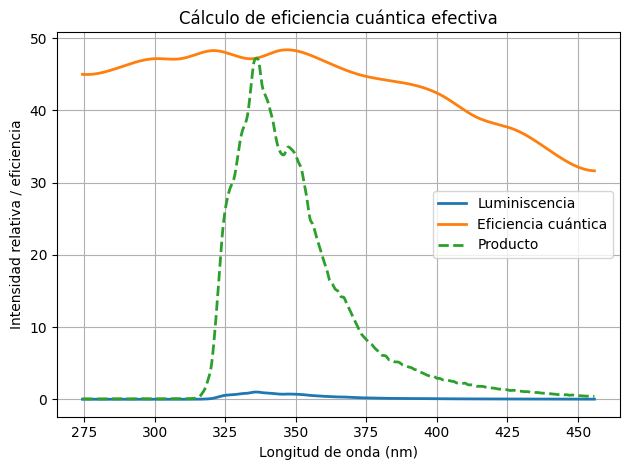

Eficiencia cuántica efectiva: 46.670983


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

# Rutas de los archivos
ruta_luminiscencia = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\codigos\Pls\psnf.txt"
ruta_eficiencia = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\adquisiciones\RENDIMIENTO CENT BIEN\sensividad pmt.csv"

# Leer archivos
lamb1, inten = np.loadtxt(ruta_luminiscencia,skiprows=1,delimiter=",", unpack=True)
lamb2, eq = np.loadtxt(ruta_eficiencia,skiprows=1,delimiter=",", unpack=True)

# Interpolación por spline
spline_lum = UnivariateSpline(lamb1, inten, s=0)
spline_eq = UnivariateSpline(lamb2, eq, s=0)
 #ESTA EN PORCENTAJE

# Definir rango común para integración
lamb_min = max(min(lamb1), min(lamb2))
lamb_max = min(max(lamb1), max(lamb2))

# Calcular área bajo la curva de luminiscencia para normalizar
area_lum, _ = quad(spline_lum, lamb_min, lamb_max)
# Función producto para integrar
def funcion_producto(lmbd):
    return spline_lum(lmbd) * spline_eq(lmbd)

# Integrar


def producto_normalizado(x):
    return (spline_lum(x) / area_lum) * spline_eq(x)

# Calcular eficiencia cuántica efectiva
eficiencia_efectiva, _ = quad(producto_normalizado, lamb_min, lamb_max)
# Mostrar resultados
print(f"Eficiencia cuántica efectiva (área bajo la curva): {eficiencia_efectiva:.6f}")

# Plot opcional para visualización
plt.figure()
lambdas = np.linspace(lamb_min, lamb_max, 1000)
plt.plot(lambdas, spline_lum(lambdas), label="Luminiscencia", lw=2)
plt.plot(lambdas, spline_eq(lambdas), label="Eficiencia cuántica", lw=2)
plt.plot(lambdas, spline_lum(lambdas)*spline_eq(lambdas), label="Producto", lw=2, linestyle="--")
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Intensidad relativa / eficiencia")
plt.title("Cálculo de eficiencia cuántica efectiva")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(f"Eficiencia cuántica efectiva: {eficiencia_efectiva:.6f}")

# nuevo

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import simpson
from scipy.signal import find_peaks
import random


plt.close("all")
get_ipython().run_line_magic('matplotlib', 'qt5')

# Parámetros configurables
resistencia = 50
umbral_deteccion = -0.009
umbral_carga_maxima = 6.5e-5
min_ancho_pico = 1
distancia_entre_picos = 15
margen_integracion = 15


# Directorios (ajusta estos paths)
directorio_trabajo = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\ycent"
carpeta_csv = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\adquisiciones\RENDIMIENTO CENT BIEN\nf\nf100nsdiv"

def graficar_senal_con_picos(archivo, tiempo_col='Time', voltaje_col='Ampl'):
    """Muestra la señal cruda con los picos detectados y áreas de integración"""
    try:
        datos = pd.read_csv(os.path.join(carpeta_csv, archivo), skiprows=4)
        tiempo = datos[tiempo_col].values
        voltaje = datos[voltaje_col].values
        
        # Calcular intervalo entre muestras
        if len(tiempo) > 1:
            intervalo = tiempo[1] - tiempo[0]
            print(f"\nIntervalo entre muestras para {archivo}: {intervalo:.3e} segundos")
            print(f"Frecuencia de muestreo: {1/intervalo:.2f} Hz")
        
        # Procesamiento para detección de picos
        linea_base = np.percentile(voltaje, 20)
        voltaje_corregido = voltaje - linea_base
        
        picos, _ = find_peaks(-voltaje_corregido, 
                             height=-umbral_deteccion,
                             width=min_ancho_pico,
                             distance=distancia_entre_picos)
        
        # Configurar gráfico
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # Graficar señal cruda
        ax.plot(tiempo, voltaje, 'b-', linewidth=0.8, label='Señal cruda')
        ax.plot(tiempo, voltaje_corregido, 'g-', linewidth=0.8, alpha=0.5, label='Señal corregida')
        ax.axhline(y=umbral_deteccion + linea_base, color='r', linestyle='--', label='Umbral de detección')
        
        # Resaltar picos y áreas de integración
        for i, pico in enumerate(picos):
            izquierda = max(0, pico - margen_integracion)
            derecha = min(len(voltaje), pico + margen_integracion)
            
            # Área de integración
            ax.axvspan(tiempo[izquierda], tiempo[derecha], color='yellow', alpha=0.3)
            
            # Marcar el pico
            ax.plot(tiempo[pico], voltaje[pico], 'ro')
            
            # Calcular carga para este pico
            carga = -simpson(voltaje_corregido[izquierda:derecha], 
                           tiempo[izquierda:derecha]) / resistencia
            
            # Etiqueta del pico
            ax.annotate(f'Pico {i+1}\nCarga: {carga:.2e} C', 
                       xy=(tiempo[pico], voltaje[pico]),
                       xytext=(10, 10), 
                       textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                       fontsize=8)
        
        ax.set_title(f'Señal cruda con picos detectados - {archivo}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Voltaje (V)')
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error al graficar {archivo}: {e}")

def procesar_adquisicion(tiempo, voltaje):
    """Procesa la señal y calcula cargas (sin mostrar gráficos)"""
    linea_base = np.percentile(voltaje, 20)
    voltaje_corregido = voltaje - linea_base
    
    picos, _ = find_peaks(-voltaje_corregido, 
                         height=-umbral_deteccion,
                         width=min_ancho_pico,
                         distance=distancia_entre_picos)
    
    if not picos.size:
        return [], tiempo[-1] - tiempo[0]
    
    cargas = []
    for pico in picos:
        izquierda = max(0, pico - margen_integracion)
        derecha = min(len(voltaje), pico + margen_integracion)
        
        carga = -simpson(voltaje_corregido[izquierda:derecha], 
                        tiempo[izquierda:derecha]) / resistencia
        
        if 0 < carga <= umbral_carga_maxima:
            cargas.append(carga)
            
    return cargas, tiempo[-1] - tiempo[0]

def procesar_carpeta(carpeta):
    """Procesa todos los archivos mostrando señal cruda con picos y haciendo cálculos"""
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]
    
    if not archivos:
        print("No se encontraron archivos CSV")
        return
    
    # Selecciona un archivo aleatorio para mostrar
    archivo_aleatorio = random.choice(archivos)
    print(f"\nMostrando archivo aleatorio: {archivo_aleatorio}")
    
    # Muestra la señal cruda con picos del archivo aleatorio
    graficar_senal_con_picos(archivo_aleatorio)
    
    # Procesa TODOS los archivos para los cálculos
    cargas_totales = []
    tiempo_total = 0
    
    for archivo in archivos:
        try:
            datos = pd.read_csv(os.path.join(carpeta, archivo), skiprows=4)
            t = datos['Time'].values
            v = datos['Ampl'].values
            
            # Calcular intervalo entre muestras para el primer archivo
            if archivo == archivos[0] and len(t) > 1:
                intervalo_muestreo = t[1] - t[0]
                print(f"\nInformación de muestreo:")
                print(f"Intervalo entre puntos: {intervalo_muestreo:.3e} segundos")
                print(f"Frecuencia de muestreo: {1/intervalo_muestreo:.2f} Hz")
            
            cargas, t_adq = procesar_adquisicion(t, v)
            cargas_totales.extend(cargas)
            tiempo_total += t_adq
            
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")
    
    if not cargas_totales:
        print("\nNo se detectaron cargas válidas. Ajusta los parámetros.")
        return
    
    cargas_arr = np.array(cargas_totales)
    carga_total = np.sum(cargas_arr)
    
    # Resultados
    print("\nRESULTADOS DEL PROCESAMIENTO:")
    print(f"- Archivos procesados: {len(archivos)}")
    print(f"- Eventos detectados: {len(cargas_arr)}")
    print(f"- Tiempo total: {tiempo_total:.3e} s")
    print(f"- Carga total: {carga_total:.3e} C")
    print(f"- Carga por segundo: {carga_total/tiempo_total:.3e} C/s")
    
    # Guarda los datos
    datos_path = os.path.join(directorio_trabajo, 'resultados_cargas.npz')
    np.savez(datos_path,
             cargas=cargas_arr,
             tiempo_total=tiempo_total,
             carga_total=carga_total)
    print(f"\nDatos guardados en: {datos_path}")

# Ejecuta el análisis completo
procesar_carpeta(carpeta_csv)


Mostrando archivo aleatorio: C1nf100nsdiv00002.csv

Intervalo entre muestras para C1nf100nsdiv00002.csv: 4.000e-10 segundos
Frecuencia de muestreo: 2499937501.56 Hz

Información de muestreo:
Intervalo entre puntos: 4.000e-10 segundos
Frecuencia de muestreo: 2500125006.25 Hz

RESULTADOS DEL PROCESAMIENTO:
- Archivos procesados: 6
- Eventos detectados: 18
- Tiempo total: 6.002e-06 s
- Carga total: 4.170e-11 C
- Carga por segundo: 6.946e-06 C/s

Datos guardados en: C:\Users\nicolas molina\Desktop\GaNAlGaN\ycent\resultados_cargas.npz


# Nf montecarlo

In [8]:
import numpy as np

def eficiencia_geometrica_monte_carlo(
    N=10000000,
    r_fuente_cm=0.92 / 2,
    d_fuente_centellador_cm=0.2,  # 2 mm
    r_centellador_cm=2.65 / 2,
    espesor_centellador_cm=0.2,  # 2 mm
    a_sensor_cm=0.4,
    b_sensor_cm=1.7
):
    """
    Simula N partículas emitidas desde la cara delantera de la fuente circular y determina
    cuántas terminan llegando al sensor a través del centellador circular.
    """

    # Generar posiciones aleatorias en la fuente circular
    r = r_fuente_cm * np.sqrt(np.random.rand(N))
    theta = 2 * np.pi * np.random.rand(N)
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    z0 = np.zeros(N)

    # Emitir al azar dentro del hemisferio frontal (emisión uniforme en ángulo sólido hemisférico)
    costheta = np.random.rand(N)
    sintheta = np.sqrt(1 - costheta**2)
    phi = 2 * np.pi * np.random.rand(N)

    dx = sintheta * np.cos(phi)
    dy = sintheta * np.sin(phi)
    dz = costheta

    # Intersección con plano del centellador a z = d_fuente_centellador_cm
    t = (d_fuente_centellador_cm - z0) / dz
    x_c = x0 + t * dx
    y_c = y0 + t * dy

    # Rechazamos los rayos que no interceptan el centellador
    en_centellador = (x_c**2 + y_c**2 <= r_centellador_cm**2)

    # Para esos, calculamos su punto final en el plano del PMT (z = d + espesor)
    t_sensor = (d_fuente_centellador_cm + espesor_centellador_cm - z0) / dz
    x_s = x0 + t_sensor * dx
    y_s = y0 + t_sensor * dy

    # Aceptamos si cae dentro del área del sensor rectangular
    en_sensor = (
        en_centellador &
        (np.abs(x_s) <= a_sensor_cm / 2) &
        (np.abs(y_s) <= b_sensor_cm / 2)
    )

    eficiencia = np.sum(en_sensor) / N
    return eficiencia

# Ejecutar estimación de eficiencia geométrica completa
eff_geom = eficiencia_geometrica_monte_carlo()
print(f"Eficiencia geométrica Monte Carlo: {eff_geom:.6f}")



# Parámetros físicos
tiempo_exposicion = 1  # segundos
actividad = 0.07  # microcuries
energia_alpha = 5.5  # MeV (aproximación)
carga_total = 3.765e-06   # C (ejemplo)  
carga_por_foton = 2.8e-12 #1.72e-12   C por fotón detectado
eficiencia_cuantica_PMT = 0.164  # del PMT

eficiencia_total = eff_geom * eficiencia_cuantica_PMT

"""
Carga por segundo: 5.264e-06 C/s para 200nsdiv

Carga por segundo: 2.129e-06 C/s para 500nsdiv

Carga por segundo: 6.946e-06 C/s para 100 nsdiv

Carga por segundo: 2.409e-06 C/s para 30x200nsdiv

Carga por segundo: 3.765e-06 C/s para 50x200nsdiv

2.465e-07 1usdiv

 Carga por segundo: 1.328e-06 C/s RUID0
"""
# Calcular rendimiento
def calcular_rendimiento_centelleo_carga(
    tiempo_exposicion_s,
    actividad_uCi,
    energia_alpha_MeV,
    carga_total_detectada_C,
    carga_por_foton_C,
    eficiencia_total
):
    actividad_Bq = actividad_uCi * 3.7e4
    N_alphas = actividad_Bq * tiempo_exposicion_s
    energia_total_MeV = N_alphas * energia_alpha_MeV
    N_fotones_detectados = carga_total_detectada_C / carga_por_foton_C
    N_fotones_emitidos = N_fotones_detectados / eficiencia_total
    rendimiento = N_fotones_emitidos / energia_total_MeV

    print(f"Número total de partículas α emitidas: {N_alphas:.2e}")
    print(f"Energía total entregada al centellador: {energia_total_MeV:.2e} MeV")
    print(f"Fotones detectados: {N_fotones_detectados:.2e}")
    print(f"Fotones emitidos (estimado): {N_fotones_emitidos:.2e}")
    print(f"\n→ Rendimiento de centelleo: {rendimiento:.3e} fotones / MeV")

    return rendimiento

# Usar nueva eficiencia total
calcular_rendimiento_centelleo_carga(
    tiempo_exposicion,
    actividad,
    energia_alpha,
    carga_total,
    carga_por_foton,
    eficiencia_total
)


Eficiencia geométrica Monte Carlo: 0.211422
Número total de partículas α emitidas: 2.59e+03
Energía total entregada al centellador: 1.42e+04 MeV
Fotones detectados: 1.34e+06
Fotones emitidos (estimado): 3.88e+07

→ Rendimiento de centelleo: 2.722e+03 fotones / MeV


np.float64(2722.395965052522)

# pvt montecarlo

In [9]:
import numpy as np

def eficiencia_geometrica_monte_carlo(
    N=10000000,
    r_fuente_cm=0.92 / 2,
    d_fuente_centellador_cm=0.2,  # 2 mm
    r_centellador_cm=2.65 / 2,
    espesor_centellador_cm=0.2,  # 2 mm
    a_sensor_cm=0.4,
    b_sensor_cm=1.7
):
    """
    Simula N partículas emitidas desde la cara delantera de la fuente circular y determina
    cuántas terminan llegando al sensor a través del centellador circular.
    """

    # Generar posiciones aleatorias en la fuente circular
    r = r_fuente_cm * np.sqrt(np.random.rand(N))
    theta = 2 * np.pi * np.random.rand(N)
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    z0 = np.zeros(N)

    # Emitir al azar dentro del hemisferio frontal (emisión uniforme en ángulo sólido hemisférico)
    costheta = np.random.rand(N)
    sintheta = np.sqrt(1 - costheta**2)
    phi = 2 * np.pi * np.random.rand(N)

    dx = sintheta * np.cos(phi)
    dy = sintheta * np.sin(phi)
    dz = costheta

    # Intersección con plano del centellador a z = d_fuente_centellador_cm
    t = (d_fuente_centellador_cm - z0) / dz
    x_c = x0 + t * dx
    y_c = y0 + t * dy

    # Rechazamos los rayos que no interceptan el centellador
    en_centellador = (x_c**2 + y_c**2 <= r_centellador_cm**2)

    # Para esos, calculamos su punto final en el plano del PMT (z = d + espesor)
    t_sensor = (d_fuente_centellador_cm + espesor_centellador_cm - z0) / dz
    x_s = x0 + t_sensor * dx
    y_s = y0 + t_sensor * dy

    # Aceptamos si cae dentro del área del sensor rectangular
    en_sensor = (
        en_centellador &
        (np.abs(x_s) <= a_sensor_cm / 2) &
        (np.abs(y_s) <= b_sensor_cm / 2)
    )

    eficiencia = np.sum(en_sensor) / N
    return eficiencia

# Ejecutar estimación de eficiencia geométrica completa
eff_geom = eficiencia_geometrica_monte_carlo()
print(f"Eficiencia geométrica Monte Carlo: {eff_geom:.6f}")

"""
Carga por segundo: 1.636e-06 C/s para 200nsdiv pvt
Carga por segundo: 2.881e-06 C/s para 100nsdiv pvt
Carga por segundo: 5.836e-06 C/s para 50nsdiv pvt
Carga por segundo: 6.011e-07 C/s para 500nsdiv pvt

Carga por segundo: 1.247e-06 C/s 30x200nsdiv

Carga por segundo: 1.426e-06 C/s 50x200nsdiv
 
 Carga por segundo: 1.328e-06 C/s RUIDO 
"""
# Parámetros físicos
tiempo_exposicion = 1  # segundos
actividad = 0.07  # microcuries
energia_alpha = 5.5  # MeV (aproximación)
carga_total = 1.426e-06  # C (ejemplo)
carga_por_foton = 2.8e-12 #  1.72e-12 C por fotón detectado
eficiencia_cuantica_PMT = 0.17  # del PMT

eficiencia_total = eff_geom * eficiencia_cuantica_PMT

# Calcular rendimiento
def calcular_rendimiento_centelleo_carga(
    tiempo_exposicion_s,
    actividad_uCi,
    energia_alpha_MeV,
    carga_total_detectada_C,
    carga_por_foton_C,
    eficiencia_total
):
    actividad_Bq = actividad_uCi * 3.7e4
    N_alphas = actividad_Bq * tiempo_exposicion_s
    energia_total_MeV = N_alphas * energia_alpha_MeV
    N_fotones_detectados = carga_total_detectada_C / carga_por_foton_C
    N_fotones_emitidos = N_fotones_detectados / eficiencia_total
    rendimiento = N_fotones_emitidos / energia_total_MeV

    print(f"Número total de partículas α emitidas: {N_alphas:.2e}")
    print(f"Energía total entregada al centellador: {energia_total_MeV:.2e} MeV")
    print(f"Fotones detectados: {N_fotones_detectados:.2e}")
    print(f"Fotones emitidos (estimado): {N_fotones_emitidos:.2e}")
    print(f"\n→ Rendimiento de centelleo: {rendimiento:.3e} fotones / MeV")

    return rendimiento

# Usar nueva eficiencia total
calcular_rendimiento_centelleo_carga(
    tiempo_exposicion,
    actividad,
    energia_alpha,
    carga_total,
    carga_por_foton,
    eficiencia_total
)


Eficiencia geométrica Monte Carlo: 0.211324
Número total de partículas α emitidas: 2.59e+03
Energía total entregada al centellador: 1.42e+04 MeV
Fotones detectados: 5.09e+05
Fotones emitidos (estimado): 1.42e+07

→ Rendimiento de centelleo: 9.952e+02 fotones / MeV


np.float64(995.1796854121043)

# eficiencia si la actividad es medida para toda la moneda 0.018

In [ ]:
import numpy as np

def eficiencia_real(
    N=10000000,
    diametro_total=2.55,          # cm
    diametro_descubierto=0.92,     # cm
    distancia=0.2,                 # cm (2mm)
    eficiencia_deteccion=0.164,    # del PMT
    actividad_total_uCi=0.07       # de TODA la fuente
):
    """
    Versión CORRECTA que considera:
    1. La actividad total (0.07 µCi) corresponde a TODA la fuente
    2. Solo la parte descubierta emite partículas útiles
    3. Geometría física completa (bloqueo por estructura)
    """
    
    # 1. Calcular fracción activa
    area_total = np.pi*(diametro_total/2)**2
    area_descubierta = np.pi*(diametro_descubierto/2)**2
    fraccion_activa = area_descubierta/area_total
    
    # 2. Generar partículas SOLO desde área descubierta
    r = (diametro_descubierto/2) * np.sqrt(np.random.rand(N))
    theta = 2*np.pi*np.random.rand(N)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # 3. Direcciones de emisión (considerando bloqueo físico)
    # Ángulo máximo sin bloqueo (geometría completa)
    theta_max = np.arctan2((diametro_total - diametro_descubierto)/2, distancia)
    phi = 2*np.pi*np.random.rand(N)
    theta = np.arcsin(np.sqrt(np.random.rand(N))) * theta_max
    
    ux = np.sin(theta)*np.cos(phi)
    uy = np.sin(theta)*np.sin(phi)
    uz = np.cos(theta)
    
    # 4. Detección (simplificado)
    detectadas = (uz > 0)  # Solo hacia adelante
    eficiencia_geom = np.sum(detectadas)/N * fraccion_activa
    
    # 5. Actividad EFECTIVA
    actividad_efectiva = actividad_total_uCi * fraccion_activa
    
    print(f"Fracción activa: {fraccion_activa:.3f}")
    print(f"Actividad efectiva: {actividad_efectiva:.3e} µCi")
    print(f"Eficiencia geométrica: {eficiencia_geom:.3e}")
    print(f"Eficiencia total: {eficiencia_geom*eficiencia_deteccion:.3e}")
    
    return {
        'actividad_efectiva': actividad_efectiva,
        'eficiencia': eficiencia_geom
        
    }

# Ejecutar
resultados = eficiencia_real()
eff_geom=eficiencia_geom*eficiencia_deteccion
# El análisis posterior debe usar:
# actividad_efectiva (NO actividad_total)
# y la eficiencia calculada aquí

# todo junto nf

In [11]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simpson

# Parámetros configurables
directorio_trabajo = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\ycent"
carpeta_csv = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\adquisiciones\RENDIMIENTO CENT BIEN\nf\nf_50x200nsdiv"
resistencia = 50
umbral_deteccion = -0.009
umbral_carga_maxima = 6.5e-5
min_ancho_pico = 1
distancia_entre_picos = 15
margen_integracion = 15


def graficar_senal_con_picos(archivo, tiempo_col='Time', voltaje_col='Ampl'):
    try:
        datos = pd.read_csv(os.path.join(carpeta_csv, archivo), skiprows=4)
        tiempo = datos[tiempo_col].values
        voltaje = datos[voltaje_col].values

        if len(tiempo) > 1:
            intervalo = tiempo[1] - tiempo[0]
            print(f"\nIntervalo entre muestras para {archivo}: {intervalo:.3e} segundos")
            print(f"Frecuencia de muestreo: {1/intervalo:.2f} Hz")

        linea_base = np.percentile(voltaje, 20)
        voltaje_corregido = voltaje - linea_base

        picos, _ = find_peaks(-voltaje_corregido,
                              height=-umbral_deteccion,
                              width=min_ancho_pico,
                              distance=distancia_entre_picos)

        fig, ax = plt.subplots(figsize=(14, 7))
        ax.plot(tiempo, voltaje, 'b-', linewidth=0.8, label='Señal cruda')
        ax.plot(tiempo, voltaje_corregido, 'g-', linewidth=0.8, alpha=0.5, label='Señal corregida')
        ax.axhline(y=umbral_deteccion + linea_base, color='r', linestyle='--', label='Umbral de detección')

        for i, pico in enumerate(picos):
            izquierda = max(0, pico - margen_integracion)
            derecha = min(len(voltaje), pico + margen_integracion)
            ax.axvspan(tiempo[izquierda], tiempo[derecha], color='yellow', alpha=0.3)
            ax.plot(tiempo[pico], voltaje[pico], 'ro')

            carga = -simpson(voltaje_corregido[izquierda:derecha],
                            tiempo[izquierda:derecha]) / resistencia

            ax.annotate(f'Pico {i+1}\nCarga: {carga:.2e} C',
                        xy=(tiempo[pico], voltaje[pico]),
                        xytext=(10, 10),
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                        fontsize=8)

        ax.set_title(f'Señal cruda con picos detectados - {archivo}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Voltaje (V)')
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al graficar {archivo}: {e}")


def procesar_adquisicion(tiempo, voltaje):
    linea_base = np.percentile(voltaje, 20)
    voltaje_corregido = voltaje - linea_base

    picos, _ = find_peaks(-voltaje_corregido,
                         height=-umbral_deteccion,
                         width=min_ancho_pico,
                         distance=distancia_entre_picos)

    if not picos.size:
        return [], tiempo[-1] - tiempo[0]

    cargas = []
    for pico in picos:
        izquierda = max(0, pico - margen_integracion)
        derecha = min(len(voltaje), pico + margen_integracion)

        carga = -simpson(voltaje_corregido[izquierda:derecha],
                        tiempo[izquierda:derecha]) / resistencia

        if 0 < carga <= umbral_carga_maxima:
            cargas.append(carga)

    return cargas, tiempo[-1] - tiempo[0]


def eficiencia_geometrica_monte_carlo(N=10000000):
    r_fuente_cm = 0.92 / 2
    d_fuente_centellador_cm = 0.2
    r_centellador_cm = 2.65 / 2
    espesor_centellador_cm = 0.2
    a_sensor_cm = 0.4
    b_sensor_cm = 1.7

    r = r_fuente_cm * np.sqrt(np.random.rand(N))
    theta = 2 * np.pi * np.random.rand(N)
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    z0 = np.zeros(N)

    costheta = np.random.rand(N)
    sintheta = np.sqrt(1 - costheta**2)
    phi = 2 * np.pi * np.random.rand(N)

    dx = sintheta * np.cos(phi)
    dy = sintheta * np.sin(phi)
    dz = costheta

    t = (d_fuente_centellador_cm - z0) / dz
    x_c = x0 + t * dx
    y_c = y0 + t * dy

    en_centellador = (x_c**2 + y_c**2 <= r_centellador_cm**2)

    t_sensor = (d_fuente_centellador_cm + espesor_centellador_cm - z0) / dz
    x_s = x0 + t_sensor * dx
    y_s = y0 + t_sensor * dy

    en_sensor = (
        en_centellador &
        (np.abs(x_s) <= a_sensor_cm / 2) &
        (np.abs(y_s) <= b_sensor_cm / 2)
    )

    eficiencia = np.sum(en_sensor) / N
    return eficiencia


def calcular_rendimiento_individual(cargas, tiempo, actividad, energia_alpha, carga_por_foton, eficiencia_total):
    actividad_Bq = actividad * 3.7e4
    N_alphas = actividad_Bq * tiempo
    energia_total_MeV = N_alphas * energia_alpha
    carga_total = np.sum(cargas)
    N_fotones_detectados = carga_total / carga_por_foton
    N_fotones_emitidos = N_fotones_detectados / eficiencia_total
    return N_fotones_emitidos / energia_total_MeV


def procesar_carpeta(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    if not archivos:
        print("No se encontraron archivos CSV")
        return

    archivo_aleatorio = random.choice(archivos)
    print(f"\nMostrando archivo aleatorio: {archivo_aleatorio}")
    graficar_senal_con_picos(archivo_aleatorio)

    cargas_totales = []
    tiempo_total = 0
    rendimientos = []

    for archivo in archivos:
        try:
            datos = pd.read_csv(os.path.join(carpeta, archivo), skiprows=4)
            t = datos['Time'].values
            v = datos['Ampl'].values
            cargas, t_adq = procesar_adquisicion(t, v)
            if cargas:
                cargas_totales.extend(cargas)
                tiempo_total += t_adq
                rendimiento_ind = calcular_rendimiento_individual(
                    cargas, t_adq, 0.07, 5.5, 2.8e-12 , eficiencia_geometrica_monte_carlo() * 0.164)
                rendimientos.append(rendimiento_ind)
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

    if not cargas_totales:
        print("\nNo se detectaron cargas válidas.")
        return

    carga_total = np.sum(cargas_totales)

    rendimiento_prom = np.mean(rendimientos)
    error_rendimiento = np.std(rendimientos) / np.sqrt(len(rendimientos))

    print(f"\n→ Rendimiento promedio: {rendimiento_prom:.3e} ± {error_rendimiento:.3e} fotones / MeV")
    return rendimiento_prom, error_rendimiento


# Ejecutar
procesar_carpeta(carpeta_csv)



Mostrando archivo aleatorio: C1nf200nsdiv00001.csv

Intervalo entre muestras para C1nf200nsdiv00001.csv: 4.000e-10 segundos
Frecuencia de muestreo: 2500000000.00 Hz

→ Rendimiento promedio: 2.724e+03 ± 2.422e+02 fotones / MeV


(np.float64(2723.54107700221), np.float64(242.16803447788718))

# todo junto pvt

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import simpson

# Parámetros configurables
directorio_trabajo = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\ycent"
carpeta_csv = r"C:\Users\nicolas molina\Desktop\GaNAlGaN\adquisiciones\RENDIMIENTO CENT BIEN\pvt\pvt_50x200nsdiv"
resistencia = 50
umbral_deteccion = -0.009
umbral_carga_maxima = 6.5e-5
min_ancho_pico = 1
distancia_entre_picos = 15
margen_integracion = 15


def graficar_senal_con_picos(archivo, tiempo_col='Time', voltaje_col='Ampl'):
    try:
        datos = pd.read_csv(os.path.join(carpeta_csv, archivo), skiprows=4)
        tiempo = datos[tiempo_col].values
        voltaje = datos[voltaje_col].values

        if len(tiempo) > 1:
            intervalo = tiempo[1] - tiempo[0]
            print(f"\nIntervalo entre muestras para {archivo}: {intervalo:.3e} segundos")
            print(f"Frecuencia de muestreo: {1/intervalo:.2f} Hz")

        linea_base = np.percentile(voltaje, 20)
        voltaje_corregido = voltaje - linea_base

        picos, _ = find_peaks(-voltaje_corregido,
                              height=-umbral_deteccion,
                              width=min_ancho_pico,
                              distance=distancia_entre_picos)

        fig, ax = plt.subplots(figsize=(14, 7))
        ax.plot(tiempo, voltaje, 'b-', linewidth=0.8, label='Señal cruda')
        ax.plot(tiempo, voltaje_corregido, 'g-', linewidth=0.8, alpha=0.5, label='Señal corregida')
        ax.axhline(y=umbral_deteccion + linea_base, color='r', linestyle='--', label='Umbral de detección')

        for i, pico in enumerate(picos):
            izquierda = max(0, pico - margen_integracion)
            derecha = min(len(voltaje), pico + margen_integracion)
            ax.axvspan(tiempo[izquierda], tiempo[derecha], color='yellow', alpha=0.3)
            ax.plot(tiempo[pico], voltaje[pico], 'ro')

            carga = -simpson(voltaje_corregido[izquierda:derecha],
                            tiempo[izquierda:derecha]) / resistencia

            ax.annotate(f'Pico {i+1}\nCarga: {carga:.2e} C',
                        xy=(tiempo[pico], voltaje[pico]),
                        xytext=(10, 10),
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
                        fontsize=8)

        ax.set_title(f'Señal cruda con picos detectados - {archivo}')
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Voltaje (V)')
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al graficar {archivo}: {e}")


def procesar_adquisicion(tiempo, voltaje):
    linea_base = np.percentile(voltaje, 20)
    voltaje_corregido = voltaje - linea_base

    picos, _ = find_peaks(-voltaje_corregido,
                         height=-umbral_deteccion,
                         width=min_ancho_pico,
                         distance=distancia_entre_picos)

    if not picos.size:
        return [], tiempo[-1] - tiempo[0]

    cargas = []
    for pico in picos:
        izquierda = max(0, pico - margen_integracion)
        derecha = min(len(voltaje), pico + margen_integracion)

        carga = -simpson(voltaje_corregido[izquierda:derecha],
                        tiempo[izquierda:derecha]) / resistencia

        if 0 < carga <= umbral_carga_maxima:
            cargas.append(carga)

    return cargas, tiempo[-1] - tiempo[0]


def eficiencia_geometrica_monte_carlo(N=10000000):
    r_fuente_cm = 0.92 / 2
    d_fuente_centellador_cm = 0.2
    r_centellador_cm = 2.65 / 2
    espesor_centellador_cm = 0.2
    a_sensor_cm = 0.4
    b_sensor_cm = 1.7

    r = r_fuente_cm * np.sqrt(np.random.rand(N))
    theta = 2 * np.pi * np.random.rand(N)
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    z0 = np.zeros(N)

    costheta = np.random.rand(N)
    sintheta = np.sqrt(1 - costheta**2)
    phi = 2 * np.pi * np.random.rand(N)

    dx = sintheta * np.cos(phi)
    dy = sintheta * np.sin(phi)
    dz = costheta

    t = (d_fuente_centellador_cm - z0) / dz
    x_c = x0 + t * dx
    y_c = y0 + t * dy

    en_centellador = (x_c**2 + y_c**2 <= r_centellador_cm**2)

    t_sensor = (d_fuente_centellador_cm + espesor_centellador_cm - z0) / dz
    x_s = x0 + t_sensor * dx
    y_s = y0 + t_sensor * dy

    en_sensor = (
        en_centellador &
        (np.abs(x_s) <= a_sensor_cm / 2) &
        (np.abs(y_s) <= b_sensor_cm / 2)
    )

    eficiencia = np.sum(en_sensor) / N
    return eficiencia


def calcular_rendimiento_individual(cargas, tiempo, actividad, energia_alpha, carga_por_foton, eficiencia_total):
    actividad_Bq = actividad * 3.7e4
    N_alphas = actividad_Bq * tiempo
    energia_total_MeV = N_alphas * energia_alpha
    carga_total = np.sum(cargas)
    N_fotones_detectados = carga_total / carga_por_foton
    N_fotones_emitidos = N_fotones_detectados / eficiencia_total
    return N_fotones_emitidos / energia_total_MeV


def procesar_carpeta(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')]

    if not archivos:
        print("No se encontraron archivos CSV")
        return

    archivo_aleatorio = random.choice(archivos)
    print(f"\nMostrando archivo aleatorio: {archivo_aleatorio}")
    graficar_senal_con_picos(archivo_aleatorio)

    cargas_totales = []
    tiempo_total = 0
    rendimientos = []

    for archivo in archivos:
        try:
            datos = pd.read_csv(os.path.join(carpeta, archivo), skiprows=4)
            t = datos['Time'].values
            v = datos['Ampl'].values
            cargas, t_adq = procesar_adquisicion(t, v)
            if cargas:
                cargas_totales.extend(cargas)
                tiempo_total += t_adq
                rendimiento_ind = calcular_rendimiento_individual(
                    cargas, t_adq, 0.07, 5.5, 2.8e-12 , eficiencia_geometrica_monte_carlo() * 0.17) #eficiencia cuantica pmt 
                rendimientos.append(rendimiento_ind)
        except Exception as e:
            print(f"Error procesando {archivo}: {e}")

    if not cargas_totales:
        print("\nNo se detectaron cargas válidas.")
        return

    carga_total = np.sum(cargas_totales)

    rendimiento_prom = np.mean(rendimientos)
    error_rendimiento = np.std(rendimientos) / np.sqrt(len(rendimientos))

    print(f"\n→ Rendimiento promedio: {rendimiento_prom:.3e} ± {error_rendimiento:.3e} fotones / MeV")
    return rendimiento_prom, error_rendimiento


# Ejecutar
procesar_carpeta(carpeta_csv)



Mostrando archivo aleatorio: C1pvt200nsdiv00000.csv

Intervalo entre muestras para C1pvt200nsdiv00000.csv: 4.000e-10 segundos
Frecuencia de muestreo: 2500000000.00 Hz

→ Rendimiento promedio: 9.948e+02 ± 1.229e+02 fotones / MeV


(np.float64(994.7534566303532), np.float64(122.86450330756483))